In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Schubfluss infolge Querkraft
## Modell: Zweizelliges dünnwandiges Profil mit in Umfangsrichtung veränderlichen E-Moduln, Schubmoduln und Wandstärken
Autor: Simeon "Moni" Gubernator

## Bemerkungen
Laufvariablen für den Schubfluss des offenen Profils starten alle im unteren Schnittpunkt, d.h. sR läuft gegen den Uhrzeigersinn, sL mit dem Uhrzeigersinn und sM nach oben

Laufvariablen für den konstanten Schubfluss in den Zellen laufen beide gegen den Uhrzeigersinn

## 0. Formeln und Funktionen definieren

### 0.0 Literatur:

Francke, Wolfgang/Friemann, Harald. Schub und Torsion in geraden Stäben. Grundlagen - Berechnungsbeispiele, Wiesbaden 2005.

### 0.1 Bestimme NC (normal center)

$ \bar y_{NC} = \frac{E S_\bar y}{E A} $

$ \bar z_{NC} = \frac{E S_\bar z}{E A} $

In [3]:
def normal_center(ES, EA):

    NC = ES/EA
    NC = np.flip(NC, 0)
    return NC

### 0.2 EA, ES, EI für Linienmodell

In [4]:
def EA_linienmodell(polygon, E, t):

    EA = 0
    for i in range(0,len(polygon)-1):
        a = np.array(polygon[i])
        b = np.array(polygon[i+1])
        E_i = E[i]
        t_i = t[i]
        Δs = np.linalg.norm(a-b)
        
        EA += E_i*Δs*t_i
    
    return EA


def ES_linienmodell(polygon, E, t):

    ES_y = 0
    ES_z = 0
    
    for i in range(0,len(polygon)-1):
        a = np.array(polygon[i])
        b = np.array(polygon[i+1])
        E_i = E[i]
        t_i = t[i]
        Δs = np.linalg.norm(a-b)
        abstand = (a+b)/2
        Δy = abstand[0]
        Δz = abstand[1]
    
        ES_y += E_i*Δz*Δs*t_i
        ES_z += E_i*Δy*Δs*t_i
        
    return ES_y, ES_z


def ES_linienmodell_umlaufend(polygon_bzgl_NC, E, t):

    ES_y = 0
    ES_z = 0
    thesum_y = []
    thesum_z = []
    
    for i in range(0,len(polygon_bzgl_NC)-1):
        a = np.array(polygon_bzgl_NC[i])
        b = np.array(polygon_bzgl_NC[i+1])
        E_i = E[i]
        t_i = t[i]
        Δs = np.linalg.norm(a-b)
        abstand = (a+b)/2
        Δy = abstand[0]
        Δz = abstand[1]
        
        ES_y += E_i*Δz*Δs*t_i
        ES_z += E_i*Δy*Δs*t_i
        
        thesum_y.append(np.array(ES_y))
        thesum_z.append(np.array(ES_z))
    
    return thesum_y, thesum_z


def EI_linienmodell_bzgl_NC(polygon_bzgl_NC, E, t):

    EI_y = 0
    EI_z = 0
    EI_yz = 0
    for i in range(0,len(polygon_bzgl_NC)-1):
        a = np.array(polygon_bzgl_NC[i])
        b = np.array(polygon_bzgl_NC[i+1])
        E_i = E[i]
        t_i = t[i]
        Δs = np.linalg.norm(a-b)
        abstand = (a+b)/2
        Δy = abstand[0]
        Δz = abstand[1]
        
        EI_y += E_i*Δz**2*Δs*t_i
        EI_z += E_i*Δy**2*Δs*t_i
        EI_yz += -E_i*Δy*Δz*Δs*t_i
    
    return EI_y, EI_z, EI_yz

### 0.4 Formeln für Berechnung des konstanten Schubflusses in den geschlossenen Zellen

In [5]:
def integral_Δs_durch_G_t(polygon_zelle_oder_rand_in_hauptachsen, schubmoduln_zelle_oder_rand, t_zelle_oder_rand):

    integral_Δs_durch_G_t = 0
    
    for i in range(0,len(polygon_zelle_oder_rand_in_hauptachsen)-1):
        a = np.array(polygon_zelle_oder_rand_in_hauptachsen[i])
        b = np.array(polygon_zelle_oder_rand_in_hauptachsen[i+1])
      
        Δs_i = np.linalg.norm(a-b)
        
        integral_Δs_durch_G_t += Δs_i/(schubmoduln_zelle_oder_rand[i]*t_zelle_oder_rand[i])
        
    return integral_Δs_durch_G_t


def integral_n_xSQ_Δs_durch_G_t(polygon_zelle_in_hauptachsen, schubmoduln_zelle, t_zelle, n_xSQ_zelle):

    integral_n_xSQ_Δs_durch_G_t = 0
    
    for i in range(0,len(polygon_zelle_in_hauptachsen)-1):
        a = np.array(polygon_zelle_in_hauptachsen[i])
        b = np.array(polygon_zelle_in_hauptachsen[i+1])
      
        Δs_i = np.linalg.norm(a-b)
        
        integral_n_xSQ_Δs_durch_G_t += (n_xSQ_zelle[i]*Δs_i)/(schubmoduln_zelle[i]*t_zelle[i])
    
    return integral_n_xSQ_Δs_durch_G_t

### 0.6 Eingeschlossene Fläche einer Zelle (Polygon) für Torsionsschub

In [6]:
def eingeschlossene_fläche_polygon(polygon):

    A = 0

    for i in range(0,len(polygon)-1):
        a = polygon[i]
        b = polygon[i+1]
    
        A += 1/2 * (b[1]*a[0] - a[1]*b[0])
    
    return A

In [7]:
def normal_center_linienmodell(profilgeometrie, emoduln, wandstärken):
    
    ES_links = ES_linienmodell(profilgeometrie[0], emoduln[0], wandstärken[0])
    ES_mitte = ES_linienmodell(profilgeometrie[1], emoduln[1], wandstärken[1])
    ES_rechts = ES_linienmodell(profilgeometrie[2], emoduln[2], wandstärken[2])
    
    EA_links = EA_linienmodell(profilgeometrie[0], emoduln[0], wandstärken[0])
    EA_mitte = EA_linienmodell(profilgeometrie[1], emoduln[1], wandstärken[1])
    EA_rechts = EA_linienmodell(profilgeometrie[2], emoduln[2], wandstärken[2])
    
    ES_ges = np.array((ES_links)) + np.array((ES_mitte)) + np.array((ES_rechts))
    EA_ges = EA_links + EA_mitte + EA_rechts
    
    NC = normal_center(ES_ges, EA_ges)
    
    return NC

In [8]:
def profilgeometrie_bzgl_NC(profilgeometrie, NC_profil):
    
    linke_seite_bzgl_NC = profilgeometrie[0] - NC_profil
    mitte_bzgl_NC = profilgeometrie[1] - NC_profil
    rechte_seite_bzgl_NC = profilgeometrie[2] - NC_profil
    
    profilgeometrie_bzgl_NC = linke_seite_bzgl_NC, mitte_bzgl_NC, rechte_seite_bzgl_NC
    
    return profilgeometrie_bzgl_NC

In [9]:
def profilgeometrie_in_hauptachsen_bzgl_NC(profilgeometrie_bzgl_NC, emoduln, wandstärken):
        
    EI_links = EI_linienmodell_bzgl_NC(profilgeometrie_bzgl_NC[0], emoduln[0], wandstärken[0])
    EI_mitte = EI_linienmodell_bzgl_NC(profilgeometrie_bzgl_NC[1], emoduln[1], wandstärken[1])
    EI_rechts = EI_linienmodell_bzgl_NC(profilgeometrie_bzgl_NC[2], emoduln[2], wandstärken[2])
    
    EI_ges = np.array((EI_links)) + np.array((EI_mitte)) + np.array((EI_rechts))
    
    [EI_y, EI_z, EI_yz] = EI_ges

    θ = -0.5*arctan(2*EI_yz/(EI_y - EI_z)) # aus TM2 Buch; hier mit Minus, da nicht das KS gedreht wird sondern die Geometrie

    rotMatrix = np.array([[np.cos(θ), -np.sin(θ)],
                          [np.sin(θ),  np.cos(θ)]])


    linke_seite_in_hauptachsen_bzgl_NC = np.matmul(rotMatrix, np.matrix.transpose(profilgeometrie_bzgl_NC[0])).T

    mitte_in_hauptachsen_bzgl_NC = np.matmul(rotMatrix, np.matrix.transpose(profilgeometrie_bzgl_NC[1])).T
    
    rechte_seite_in_hauptachsen_bzgl_NC = np.matmul(rotMatrix, np.matrix.transpose(profilgeometrie_bzgl_NC[2])).T

    profilgeometrie_in_hauptachsen_bzgl_NC = linke_seite_in_hauptachsen_bzgl_NC, mitte_in_hauptachsen_bzgl_NC, rechte_seite_in_hauptachsen_bzgl_NC

    return profilgeometrie_in_hauptachsen_bzgl_NC

In [10]:
def schubfluss_profil_geöffnet_infolge_Q(profilgeometrie_in_hauptachsen_bzgl_NC, emoduln, wandstärken, querkraft):
    
    ES_umlaufend_links = ES_linienmodell_umlaufend(profilgeometrie_in_hauptachsen_bzgl_NC[0], emoduln[0], wandstärken[0])
    ES_umlaufend_mitte = ES_linienmodell_umlaufend(profilgeometrie_in_hauptachsen_bzgl_NC[1], emoduln[1], wandstärken[1])
    ES_umlaufend_rechts = ES_linienmodell_umlaufend(profilgeometrie_in_hauptachsen_bzgl_NC[2], emoduln[2], wandstärken[2])

    EI_hauptachsen_links = EI_linienmodell_bzgl_NC(profilgeometrie_in_hauptachsen_bzgl_NC[0], emoduln[0], wandstärken[0])
    EI_hauptachsen_mitte = EI_linienmodell_bzgl_NC(profilgeometrie_in_hauptachsen_bzgl_NC[1], emoduln[1], wandstärken[1])
    EI_hauptachsen_rechts = EI_linienmodell_bzgl_NC(profilgeometrie_in_hauptachsen_bzgl_NC[2], emoduln[2], wandstärken[2])
    
    EI_hauptachsen_ges = np.array((EI_hauptachsen_links)) + np.array((EI_hauptachsen_mitte)) + np.array((EI_hauptachsen_rechts))

    
    ES_y_links = np.array(ES_umlaufend_links[0])
    ES_y_mitte = np.array(ES_umlaufend_mitte[0])
    ES_y_rechts = np.array(ES_umlaufend_rechts[0])
    
    EI_y_gesamt = EI_hauptachsen_ges[0]

    Q_z = querkraft[1]
    
    n_xSQz_links = -(Q_z/EI_y_gesamt)*ES_y_links
    n_xSQz_mitte = -(Q_z/EI_y_gesamt)*ES_y_mitte
    n_xSQz_rechts = -(Q_z/EI_y_gesamt)*ES_y_rechts

    
    ES_z_links = np.array(ES_umlaufend_links[1])
    ES_z_mitte = np.array(ES_umlaufend_mitte[1])
    ES_z_rechts = np.array(ES_umlaufend_rechts[1])
    
    EI_z_gesamt = EI_hauptachsen_ges[1]

    Q_y = querkraft[0]
    
    n_xSQy_links = -(Q_y/EI_z_gesamt)*ES_z_links
    n_xSQy_mitte = -(Q_y/EI_z_gesamt)*ES_z_mitte
    n_xSQy_rechts = -(Q_y/EI_z_gesamt)*ES_z_rechts
    
    return n_xSQz_links, n_xSQz_mitte, n_xSQz_rechts, n_xSQy_links, n_xSQy_mitte, n_xSQy_rechts

In [11]:
def profildaten_in_entgegengesetzte_richtung(profildaten):
    
    profildaten_linke_seite_gegen = np.flip(profildaten[0], 0)
    profildaten_mitte_gegen = np.flip(profildaten[1], 0)
    profildaten_rechte_seite_gegen = np.flip(profildaten[2], 0)
    
    return profildaten_linke_seite_gegen, profildaten_mitte_gegen, profildaten_rechte_seite_gegen

In [12]:
def profildaten_für_zellen(profildaten):
    
    profildaten_linke_seite_gegen = np.flip(profildaten[0], 0)
    profildaten_mitte_gegen = np.flip(profildaten[1], 0)
    profildaten_rechte_seite_gegen = np.flip(profildaten[2], 0)
    
    profildaten_zelle_links = np.concatenate((profildaten_linke_seite_gegen, profildaten[1]))
    profildaten_zelle_rechts = np.concatenate((profildaten[2], profildaten_mitte_gegen))

    return profildaten_zelle_links, profildaten_zelle_rechts

In [13]:
def konstanter_schubfluss_in_zellen_infolge_Q(profilgeometrie_in_hauptachsen_bzgl_NC, schubmoduln, wandstärken, schubfluss_profil_geöffnet_infolge_Q):
    
    # berechne nötige Integrale   
    
    integral_Δs_durch_G_t_linke_seite = integral_Δs_durch_G_t(profilgeometrie_in_hauptachsen_bzgl_NC[0], schubmoduln[0], wandstärken[0])
    
    integral_Δs_durch_G_t_mitte = integral_Δs_durch_G_t(profilgeometrie_in_hauptachsen_bzgl_NC[1], schubmoduln[1], wandstärken[1])
    
    integral_Δs_durch_G_t_rechte_seite = integral_Δs_durch_G_t(profilgeometrie_in_hauptachsen_bzgl_NC[2], schubmoduln[2], wandstärken[2])

    
    integral_Δs_durch_G_t_zelle_links = integral_Δs_durch_G_t_linke_seite + integral_Δs_durch_G_t_mitte
    integral_Δs_durch_G_t_zelle_rechts = integral_Δs_durch_G_t_rechte_seite + integral_Δs_durch_G_t_mitte
    integral_Δs_durch_G_t_rand = integral_Δs_durch_G_t_mitte

    integral_n_xSQz_Δs_durch_G_t_linke_seite = integral_n_xSQ_Δs_durch_G_t(profilgeometrie_in_hauptachsen_bzgl_NC[0], schubmoduln[0], wandstärken[0], schubfluss_profil_geöffnet_infolge_Q[0])

    integral_n_xSQz_Δs_durch_G_t_mitte = integral_n_xSQ_Δs_durch_G_t(profilgeometrie_in_hauptachsen_bzgl_NC[1], schubmoduln[1], wandstärken[1], schubfluss_profil_geöffnet_infolge_Q[1])

    integral_n_xSQz_Δs_durch_G_t_rechte_seite = integral_n_xSQ_Δs_durch_G_t(profilgeometrie_in_hauptachsen_bzgl_NC[2], schubmoduln[2], wandstärken[2], schubfluss_profil_geöffnet_infolge_Q[2])

    
    integral_n_xSQy_Δs_durch_G_t_linke_seite = integral_n_xSQ_Δs_durch_G_t(profilgeometrie_in_hauptachsen_bzgl_NC[0], schubmoduln[0], wandstärken[0], schubfluss_profil_geöffnet_infolge_Q[3])

    integral_n_xSQy_Δs_durch_G_t_mitte = integral_n_xSQ_Δs_durch_G_t(profilgeometrie_in_hauptachsen_bzgl_NC[1], schubmoduln[1], wandstärken[1], schubfluss_profil_geöffnet_infolge_Q[4])

    integral_n_xSQy_Δs_durch_G_t_rechte_seite = integral_n_xSQ_Δs_durch_G_t(profilgeometrie_in_hauptachsen_bzgl_NC[2], schubmoduln[2], wandstärken[2], schubfluss_profil_geöffnet_infolge_Q[5])
    
    # die Vorzeichen in der Matrix und im Lösungsvektor orientieren sich an "Schub und Torsion in geraden Stäben"
    # sie sind so definiert, da die Laufvariable des konstanten Schubflusses in den Zellen gegen den Uhrzeigersinn läuft
    # die Vorzeichen in y ergeben sich dadurch, dass die Werte in jedem Teilabschnitt positiv in U_i eingehen, wenn die Laufvariable des konstanten Schubflusses T_i mit der des Schubflusses im offenen Profil übereinstimmen - sonst negativ

    a = integral_Δs_durch_G_t_zelle_links
    d = integral_Δs_durch_G_t_zelle_rechts
    b = -integral_Δs_durch_G_t_rand
    c = -integral_Δs_durch_G_t_rand

    e = -(-integral_n_xSQz_Δs_durch_G_t_linke_seite + integral_n_xSQz_Δs_durch_G_t_mitte)
    f = -(integral_n_xSQz_Δs_durch_G_t_rechte_seite - integral_n_xSQz_Δs_durch_G_t_mitte)

    g = -(-integral_n_xSQy_Δs_durch_G_t_linke_seite + integral_n_xSQy_Δs_durch_G_t_mitte)
    h = -(integral_n_xSQy_Δs_durch_G_t_rechte_seite - integral_n_xSQy_Δs_durch_G_t_mitte)

    A = np.matrix([[a, b], [c, d]])
    y = np.array([e,f]).T
    z = np.array([g,h]).T

    n_xS0_links_infolge_Qz, n_xS0_rechts_infolge_Qz = np.linalg.solve(A, y)
    n_xS0_links_infolge_Qy, n_xS0_rechts_infolge_Qy = np.linalg.solve(A, z)


    return n_xS0_links_infolge_Qz, n_xS0_rechts_infolge_Qz, n_xS0_links_infolge_Qy, n_xS0_rechts_infolge_Qy

In [14]:
def schubfluss_gesamt_infolge_Q(schubfluss_profil_geöffnet_infolge_Q, konstanter_schubfluss_in_zellen_infolge_Q):
    
    n_xSQz_links = schubfluss_profil_geöffnet_infolge_Q[0]
    n_xSQz_mitte = schubfluss_profil_geöffnet_infolge_Q[1]
    n_xSQz_rechts = schubfluss_profil_geöffnet_infolge_Q[2]
    
    n_xSQy_links = schubfluss_profil_geöffnet_infolge_Q[3]
    n_xSQy_mitte = schubfluss_profil_geöffnet_infolge_Q[4]
    n_xSQy_rechts = schubfluss_profil_geöffnet_infolge_Q[5]
    
    n_xS0_links_infolge_Qz = konstanter_schubfluss_in_zellen_infolge_Q[0]
    n_xS0_rechts_infolge_Qz = konstanter_schubfluss_in_zellen_infolge_Q[1]
    
    n_xS0_links_infolge_Qy = konstanter_schubfluss_in_zellen_infolge_Q[2]
    n_xS0_rechts_infolge_Qy = konstanter_schubfluss_in_zellen_infolge_Q[3]
    
    # Werte werden addiert, wenn Laufrichtungen von n_xSQ mit n_xS0 übereinstimmen, ansonsten wird n_xS0 subtrahiert
    
    n_xSQz_ges_links = n_xSQz_links - n_xS0_links_infolge_Qz
    n_xSQz_ges_mitte = n_xSQz_mitte - n_xS0_rechts_infolge_Qz + n_xS0_links_infolge_Qz
    n_xSQz_ges_rechts = n_xSQz_rechts + n_xS0_rechts_infolge_Qz
    
    n_xSQy_ges_links = n_xSQy_links - n_xS0_links_infolge_Qy
    n_xSQy_ges_mitte = n_xSQy_mitte - n_xS0_rechts_infolge_Qy + n_xS0_links_infolge_Qy
    n_xSQy_ges_rechts = n_xSQy_rechts + n_xS0_rechts_infolge_Qy   
    
    return n_xSQz_ges_links, n_xSQz_ges_mitte, n_xSQz_ges_rechts, n_xSQy_ges_links, n_xSQy_ges_mitte, n_xSQy_ges_rechts

In [15]:
def schubfluss_gesamt_infolge_Q_überlagert(schubfluss_gesamt_infolge_Q):
    
    n_xSQz_ges_links = schubfluss_gesamt_infolge_Q[0]
    n_xSQz_ges_mitte = schubfluss_gesamt_infolge_Q[1]
    n_xSQz_ges_rechts = schubfluss_gesamt_infolge_Q[2]
    n_xSQy_ges_links = schubfluss_gesamt_infolge_Q[3]
    n_xSQy_ges_mitte = schubfluss_gesamt_infolge_Q[4]
    n_xSQy_ges_rechts = schubfluss_gesamt_infolge_Q[5]
    
    n_xSQ_ges_links = n_xSQz_ges_links + n_xSQy_ges_links
    n_xSQ_ges_mitte = n_xSQz_ges_mitte + n_xSQy_ges_mitte
    n_xSQ_ges_rechts = n_xSQz_ges_rechts + n_xSQy_ges_rechts
    
    return n_xSQ_ges_links, n_xSQ_ges_mitte, n_xSQ_ges_rechts

In [16]:
def schubfluss_für_plot_über_profil(profilgeometrie, schubfluss):
    
    profil_links = profilgeometrie[0]
    profil_mitte = profilgeometrie[1]
    profil_rechts = profilgeometrie[2]
    
    schubfluss_ges_links = schubfluss[0]
    schubfluss_ges_mitte = schubfluss[1]
    schubfluss_ges_rechts = schubfluss[2]
       
    punkt_am_profil_links = []
    punkt_am_profil_mitte = []
    punkt_am_profil_rechts = []
    
    
    for i in range(0,len(profil_links)-1):
        a = np.array(profil_links[i])
        b = np.array(profil_links[i+1])
        
        m = (a+b)/2
        n = b-a
    
        normalenvektor = [n[1], -n[0]]/np.linalg.norm(n)
        
        punkt_am_profil_links_i = normalenvektor*schubfluss_ges_links[i] + m
        punkt_am_profil_links.append(punkt_am_profil_links_i)
    
    
    for i in range(0,len(profil_mitte)-1):
        a = np.array(profil_mitte[i])
        b = np.array(profil_mitte[i+1])
        
        m = (a+b)/2
        n = b-a
    
        normalenvektor = [n[1], -n[0]]/np.linalg.norm(n)
        
        punkt_am_profil_mitte_i = normalenvektor*schubfluss_ges_mitte[i] + m
        punkt_am_profil_mitte.append(punkt_am_profil_mitte_i)
        
    
    for i in range(0,len(profil_rechts)-1):
        a = np.array(profil_rechts[i])
        b = np.array(profil_rechts[i+1])
        
        m = (a+b)/2
        n = b-a
    
        normalenvektor = [n[1], -n[0]]/np.linalg.norm(n)
        
        punkt_am_profil_rechts_i = normalenvektor*schubfluss_ges_rechts[i] + m
        punkt_am_profil_rechts.append(punkt_am_profil_rechts_i)
        
        
    return np.array(punkt_am_profil_links), np.array(punkt_am_profil_mitte), np.array(punkt_am_profil_rechts)

In [17]:
def profildaten_aneinanderreihen(profildaten):
    
    profildaten_aneinander = np.concatenate((profildaten[0], profildaten[1], profildaten[2]))
    
    return np.array(profildaten_aneinander)

In [18]:
def momente_durch_schubfluss(profilgeometrie_in_hauptachsen_bzgl_NC, schubfluss_gesamt_infolge_Q):
    
    profil_links = profilgeometrie_in_hauptachsen_bzgl_NC[0]
    profil_mitte = profilgeometrie_in_hauptachsen_bzgl_NC[1]
    profil_rechts = profilgeometrie_in_hauptachsen_bzgl_NC[2]
    
    n_xSQz_ges_links = schubfluss_gesamt_infolge_Q[0]
    n_xSQz_ges_mitte = schubfluss_gesamt_infolge_Q[1]
    n_xSQz_ges_rechts = schubfluss_gesamt_infolge_Q[2]
    n_xSQy_ges_links = schubfluss_gesamt_infolge_Q[3]
    n_xSQy_ges_mitte = schubfluss_gesamt_infolge_Q[4]
    n_xSQy_ges_rechts = schubfluss_gesamt_infolge_Q[5]
    
    
    moment_links_infolge_Qz = 0
    moment_mitte_infolge_Qz = 0
    moment_rechts_infolge_Qz = 0
    
    moment_links_infolge_Qy = 0
    moment_mitte_infolge_Qy = 0
    moment_rechts_infolge_Qy = 0
    
    
    for i in range(0,len(profil_links)-1):
        a = np.array(profil_links[i])
        b = np.array(profil_links[i+1])
        
        m = (a+b)/2
        n = b-a
    
        r_senkrecht_mal_norm_n_i = abs(np.cross(m,n))
        
        moment_links_infolge_Qz += r_senkrecht_mal_norm_n_i*n_xSQz_ges_links[i]
        moment_links_infolge_Qy += r_senkrecht_mal_norm_n_i*n_xSQy_ges_links[i]
        
        
    for i in range(0,len(profil_mitte)-1):
        a = np.array(profil_mitte[i])
        b = np.array(profil_mitte[i+1])
        
        m = (a+b)/2
        n = b-a
    
        r_senkrecht_mal_norm_n_i = abs(np.cross(m,n))
        
        moment_mitte_infolge_Qz += r_senkrecht_mal_norm_n_i*n_xSQz_ges_mitte[i]
        moment_mitte_infolge_Qy += r_senkrecht_mal_norm_n_i*n_xSQy_ges_mitte[i]
        
        
    for i in range(0,len(profil_rechts)-1):
        a = np.array(profil_rechts[i])
        b = np.array(profil_rechts[i+1])
        
        m = (a+b)/2
        n = b-a
    
        r_senkrecht_mal_norm_n_i = abs(np.cross(m,n))
        
        moment_rechts_infolge_Qz += r_senkrecht_mal_norm_n_i*n_xSQz_ges_rechts[i]
        moment_rechts_infolge_Qy += r_senkrecht_mal_norm_n_i*n_xSQy_ges_rechts[i]
    
       
    return moment_links_infolge_Qz, moment_mitte_infolge_Qz, moment_rechts_infolge_Qz, moment_links_infolge_Qy, moment_mitte_infolge_Qy, moment_rechts_infolge_Qy

In [19]:
def schubmittelpunkt_in_hauptachsen_bzgl_NC(momente_durch_schubfluss, querkraft):
    
    moment_links_infolge_Qz = momente_durch_schubfluss[0]
    moment_mitte_infolge_Qz = momente_durch_schubfluss[1]
    moment_rechts_infolge_Qz = momente_durch_schubfluss[2]
    moment_links_infolge_Qy = momente_durch_schubfluss[3]
    moment_mitte_infolge_Qy = momente_durch_schubfluss[4]
    moment_rechts_infolge_Qy = momente_durch_schubfluss[5]
    
    Q_y = querkraft[0]
    Q_z = querkraft[1]

    # linksdrehend positiv
    moment_infolge_Qz_ges = -moment_links_infolge_Qz - moment_mitte_infolge_Qz + moment_rechts_infolge_Qz
    moment_infolge_Qy_ges = -moment_links_infolge_Qy - moment_mitte_infolge_Qy + moment_rechts_infolge_Qy

    if Q_z == 0:
        y_SMP_bzgl_NC = 0
    else:
        y_SMP_bzgl_NC = moment_infolge_Qz_ges/Q_z
    
    
    if Q_y == 0:
        z_SMP_bzgl_NC = 0
    else:
        z_SMP_bzgl_NC = moment_infolge_Qy_ges/Q_y
    

    return y_SMP_bzgl_NC, z_SMP_bzgl_NC

### Input Geometrie: profilgeometrie = linke_seite, mitte, rechte_seite
3 numpy arrays.

rechte_seite beginnt unten und läuft gegen den Uhrzeigersinn.

linke_seite beginnt unten und läuft im Uhrzeigersinn.

mitte beginnt unten und läuft nach oben.

In [20]:
unten_rechts = np.transpose(np.outer(np.array(((3),(0))), np.linspace(0,1,300)))
unten_rechts = unten_rechts + np.array((1*ones(len(unten_rechts)), zeros(len(unten_rechts)))).T

rechts = np.transpose(np.outer(np.array(((0),(1))), np.linspace(0,1,100)))
rechts = rechts + np.array((4*ones(len(rechts)), zeros(len(rechts)))).T

ecke_rechts = np.transpose(np.outer(np.array(((2),(-1))), np.linspace(1,0,224)))
ecke_rechts = ecke_rechts + np.array((2*ones(len(ecke_rechts)), 2*ones(len(ecke_rechts)))).T

oben_rechts = np.transpose(np.outer(np.array(((1),(0))), np.linspace(1,0,100)))
oben_rechts = oben_rechts + np.array((1*ones(len(oben_rechts)), 2*ones(len(oben_rechts)))).T

rechte_seite = np.vstack((unten_rechts, rechts[1:,:], ecke_rechts[1:,:], oben_rechts[1:,:]))

unten_links = np.transpose(np.outer(np.array(((1),(0))), np.linspace(1,0,100)))

links = np.transpose(np.outer(np.array(((0),(2))), np.linspace(0,1,200)))

oben_links = np.transpose(np.outer(np.array(((1),(0))), np.linspace(0,1,100)))
oben_links = oben_links + np.array((zeros(len(oben_links)), 2*ones(len(oben_links)))).T

linke_seite = np.vstack((unten_links, links[1:,:], oben_links[1:,:]))

mitte = np.transpose(np.outer(np.array(((0),(2))), np.linspace(0,1,200)))
mitte = mitte + np.array((1*ones(len(mitte)), zeros(len(mitte)))).T


profilgeometrie_an_stützstelle = linke_seite, mitte, rechte_seite

### Input: Querkraft, Wandstärken, E-Moduln und Schubmoduln

Laufrichtungen von t, E und G entsprechen den Laufrichtungen der Geometrie.

In [21]:
querkraft_an_stützstelle = [1000,1000]

wandstärken_rechts = 0.001*np.ones(len(rechte_seite)-1)
wandstärken_links = 0.001*np.ones(len(linke_seite)-1)
wandstärken_mitte = 0.001*np.ones(len(mitte)-1)

emoduln_rechts = np.ones(len(rechte_seite)-1)
emoduln_links = np.ones(len(linke_seite)-1)
emoduln_mitte = np.ones(len(mitte)-1)

schubmoduln_rechts = np.ones(len(rechte_seite)-1)
schubmoduln_links = np.ones(len(linke_seite)-1)
schubmoduln_mitte = np.ones(len(mitte)-1)

wandstärken_an_stützstelle = wandstärken_links, wandstärken_mitte, wandstärken_rechts
emoduln_an_stützstelle = emoduln_links, emoduln_mitte, emoduln_rechts
schubmoduln_an_stützstelle = schubmoduln_links, schubmoduln_mitte, schubmoduln_rechts

In [22]:
# Berechnung NC_profil

NC_profil_an_stützstelle = normal_center_linienmodell(profilgeometrie_an_stützstelle, emoduln_an_stützstelle, wandstärken_an_stützstelle)


# profilgeometrie auf NC_profil beziehen

profilgeometrie_an_stützstelle_bzgl_NC = profilgeometrie_bzgl_NC(profilgeometrie_an_stützstelle, NC_profil_an_stützstelle)


# profilgeometrie ins Hauptachsensystem drehen

profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC = profilgeometrie_in_hauptachsen_bzgl_NC(profilgeometrie_an_stützstelle_bzgl_NC, emoduln_an_stützstelle, wandstärken_an_stützstelle)


# Schubfluss Profil geöffnet infolge Q

schubfluss_an_stützstelle_profil_geöffnet_infolge_Q = schubfluss_profil_geöffnet_infolge_Q(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, emoduln_an_stützstelle, wandstärken_an_stützstelle, querkraft_an_stützstelle)


# Konstante Schubflüsse in den Zellen infolge Q

konstanter_schubfluss_an_stützstelle_in_zellen_infolge_Q = konstanter_schubfluss_in_zellen_infolge_Q(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, schubmoduln_an_stützstelle, wandstärken_an_stützstelle, schubfluss_an_stützstelle_profil_geöffnet_infolge_Q)


# Gesamtschubfluss im zweizelligen Profil

schubfluss_gesamt_an_stützstelle_infolge_Q = schubfluss_gesamt_infolge_Q(schubfluss_an_stützstelle_profil_geöffnet_infolge_Q, konstanter_schubfluss_an_stützstelle_in_zellen_infolge_Q)


# Gesamtschubfluss im zweizelligen Profil überlagert

schubfluss_gesamt_an_stützstelle_infolge_Q_überlagert = schubfluss_gesamt_infolge_Q_überlagert(schubfluss_gesamt_an_stützstelle_infolge_Q)


# Durch Schubfluss hervorgerufene Momente

momente_durch_schubfluss_an_stützstelle = momente_durch_schubfluss(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, schubfluss_gesamt_an_stützstelle_infolge_Q)


# Schubmittelpunkt

schubmittelpunkt_an_stützstelle_in_hauptachsen_bzgl_NC = schubmittelpunkt_in_hauptachsen_bzgl_NC(momente_durch_schubfluss_an_stützstelle, querkraft_an_stützstelle)

In [23]:
schubmittelpunkt_an_stützstelle_in_hauptachsen_bzgl_NC

(-0.2791859348649149, -0.08350258431067166)

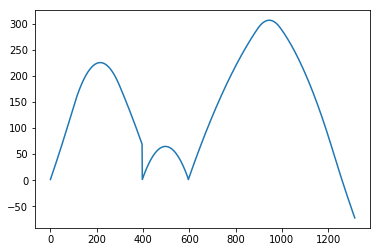

In [24]:
links = schubfluss_an_stützstelle_profil_geöffnet_infolge_Q[0]
mitte =  schubfluss_an_stützstelle_profil_geöffnet_infolge_Q[1]
rechts =  schubfluss_an_stützstelle_profil_geöffnet_infolge_Q[2]

n_xSQ_ges = np.concatenate((links, mitte, rechts))

plot(n_xSQ_ges)

In [25]:
NC_profil_an_stützstelle

array([1.71563065, 0.89559089])

### Plot Schubfluss gesamt infolge Q überlagert

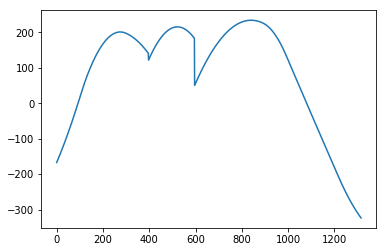

In [26]:
n_xSQ_ges_links = schubfluss_gesamt_an_stützstelle_infolge_Q_überlagert[0]
n_xSQ_ges_mitte = schubfluss_gesamt_an_stützstelle_infolge_Q_überlagert[1]
n_xSQ_ges_rechts = schubfluss_gesamt_an_stützstelle_infolge_Q_überlagert[2]

n_xSQ_ges = np.concatenate((n_xSQ_ges_links, n_xSQ_ges_mitte, n_xSQ_ges_rechts))

plot(n_xSQ_ges)

### Plot Schubfluss gesamt infolge Q überlagert über Profil

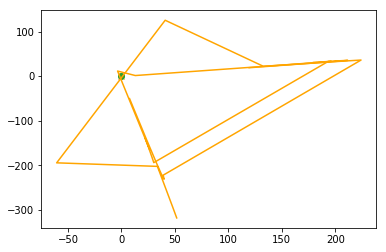

In [27]:
schubfluss_für_plot = schubfluss_für_plot_über_profil(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, schubfluss_gesamt_an_stützstelle_infolge_Q_überlagert)

schubfluss_für_plot_links = schubfluss_für_plot[0]
schubfluss_für_plot_mitte = schubfluss_für_plot[1]
schubfluss_für_plot_rechts = schubfluss_für_plot[2]

gesamtprofil = profildaten_aneinanderreihen(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC)

SMP = schubmittelpunkt_an_stützstelle_in_hauptachsen_bzgl_NC

plot(gesamtprofil[:,0], gesamtprofil[:,1])
plot(0,0, 'x')
plot(SMP[0], SMP[1], 'o')
plot(schubfluss_für_plot_links[:,0], schubfluss_für_plot_links[:,1], 'orange')
plot(schubfluss_für_plot_mitte[:,0], schubfluss_für_plot_mitte[:,1], 'orange')
plot(schubfluss_für_plot_rechts[:,0], schubfluss_für_plot_rechts[:,1], 'orange')

### Prüfe: Integral des Gesamtschubflusses muss Q ergeben

In [28]:
def integral_n_xSQ_ges_Δs(profilgeometrie_in_hauptachsen_bzgl_NC, schubfluss_gesamt_infolge_Q_überlagert):

    
    profil_links = profilgeometrie_in_hauptachsen_bzgl_NC[0]
    profil_mitte = profilgeometrie_in_hauptachsen_bzgl_NC[1]
    profil_rechts = profilgeometrie_in_hauptachsen_bzgl_NC[2]
    
    n_xSQ_ges_links = schubfluss_gesamt_infolge_Q_überlagert[0]
    n_xSQ_ges_mitte = schubfluss_gesamt_infolge_Q_überlagert[1]
    n_xSQ_ges_rechts = schubfluss_gesamt_infolge_Q_überlagert[2]
    
    
    integral_n_xSQ_ges_Δs_links = 0
    integral_n_xSQ_ges_Δs_mitte = 0
    integral_n_xSQ_ges_Δs_rechts = 0
    
    
    for i in range(0,len(profil_links)-1):
        a = np.array(profil_links[i])
        b = np.array(profil_links[i+1])
        
        integral_n_xSQ_ges_Δs_links += n_xSQ_ges_links[i]*(b-a)
        
    for i in range(0,len(profil_mitte)-1):
        a = np.array(profil_mitte[i])
        b = np.array(profil_mitte[i+1])
        
        integral_n_xSQ_ges_Δs_mitte += n_xSQ_ges_mitte[i]*(b-a)
        
    for i in range(0,len(profil_rechts)-1):
        a = np.array(profil_rechts[i])
        b = np.array(profil_rechts[i+1])
        
        integral_n_xSQ_ges_Δs_rechts += n_xSQ_ges_rechts[i]*(b-a)
        
    integral_n_xSQ_ges_Δs = integral_n_xSQ_ges_Δs_links + integral_n_xSQ_ges_Δs_mitte + integral_n_xSQ_ges_Δs_rechts
    
    return integral_n_xSQ_ges_Δs


integral_n_xSQ_ges_Δs(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, schubfluss_gesamt_an_stützstelle_infolge_Q_überlagert)

array([1001.7633393 , 1000.31278467])

### Prüfe Kontinuitätsbedingung

In [29]:
def kontinuitätsbedingung_schubfluss(profilgeometrie_in_hauptachsen_bzgl_NC, schubmoduln, wandstärken, schubfluss_gesamt):
    
    integral_n_xSQ_ges_Δs_durch_G_t_linke_seite = 0
    integral_n_xSQ_ges_Δs_durch_G_t_mitte = 0
    integral_n_xSQ_ges_Δs_durch_G_t_rechte_seite = 0
       
    profil_links = profilgeometrie_in_hauptachsen_bzgl_NC[0]
    profil_mitte = profilgeometrie_in_hauptachsen_bzgl_NC[1]
    profil_rechts = profilgeometrie_in_hauptachsen_bzgl_NC[2]
    
    n_xSQ_ges_links = schubfluss_gesamt[0]
    n_xSQ_ges_mitte = schubfluss_gesamt[1]
    n_xSQ_ges_rechts = schubfluss_gesamt[2]
    
    schubmoduln_links = schubmoduln[0]
    schubmoduln_mitte = schubmoduln[1]
    schubmoduln_rechts = schubmoduln[2]
    
    wandstärken_links = wandstärken[0]
    wandstärken_mitte = wandstärken[1]
    wandstärken_rechts = wandstärken[2]
    
    
    for i in range(0,len(profil_links)-1):
        a = np.array(profil_links[i])
        b = np.array(profil_links[i+1])
      
        Δs_i = np.linalg.norm(a-b)
        
        integral_n_xSQ_ges_Δs_durch_G_t_linke_seite += (n_xSQ_ges_links[i]*Δs_i)/(schubmoduln_links[i]*wandstärken_links[i])

        
    for i in range(0,len(profil_mitte)-1):
        a = np.array(profil_mitte[i])
        b = np.array(profil_mitte[i+1])
      
        Δs_i = np.linalg.norm(a-b)
        
        integral_n_xSQ_ges_Δs_durch_G_t_mitte += (n_xSQ_ges_mitte[i]*Δs_i)/(schubmoduln_mitte[i]*wandstärken_mitte[i])

        
    for i in range(0,len(profil_rechts)-1):
        a = np.array(profil_rechts[i])
        b = np.array(profil_rechts[i+1])
      
        Δs_i = np.linalg.norm(a-b)
        
        integral_n_xSQ_ges_Δs_durch_G_t_rechte_seite += (n_xSQ_ges_rechts[i]*Δs_i)/(schubmoduln_rechts[i]*wandstärken_rechts[i])
        
        
    integral_n_xSQ_ges_Δs_durch_G_t_zelle_links = integral_n_xSQ_ges_Δs_durch_G_t_linke_seite - integral_n_xSQ_ges_Δs_durch_G_t_mitte
    integral_n_xSQ_ges_Δs_durch_G_t_zelle_rechts = integral_n_xSQ_ges_Δs_durch_G_t_rechte_seite - integral_n_xSQ_ges_Δs_durch_G_t_mitte

    
    return integral_n_xSQ_ges_Δs_durch_G_t_zelle_links, integral_n_xSQ_ges_Δs_durch_G_t_zelle_rechts


kontinuitätsbedingung_schubfluss(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, schubmoduln_an_stützstelle, wandstärken_an_stützstelle, schubfluss_gesamt_an_stützstelle_infolge_Q_überlagert)

(5.820766091346741e-11, 9.89530235528946e-10)

## Schubfluss infolge Torsion
nach Schürmann, Helmut: Konstruktiver Leichtbau I (Kapitel 3.5)

In [30]:
def schubfluss_infolge_torsion(profilgeometrie_in_hauptachsen_bzgl_NC, schubmoduln, wandstärken, torsionsmoment):

    profil_links = profilgeometrie_in_hauptachsen_bzgl_NC[0]
    profil_mitte = profilgeometrie_in_hauptachsen_bzgl_NC[1]
    profil_rechts = profilgeometrie_in_hauptachsen_bzgl_NC[2]
    
    schubmoduln_links = schubmoduln[0]
    schubmoduln_mitte = schubmoduln[1]
    schubmoduln_rechts = schubmoduln[2]
    
    wandstärken_links = wandstärken[0]
    wandstärken_mitte = wandstärken[1]
    wandstärken_rechts = wandstärken[2]
        
    
    a = integral_Δs_durch_G_t_linke_seite = integral_Δs_durch_G_t(profil_links, schubmoduln_links, wandstärken_links)
    b = integral_Δs_durch_G_t_mitte = integral_Δs_durch_G_t(profil_mitte, schubmoduln_mitte, wandstärken_mitte)
    c = integral_Δs_durch_G_t_rechte_seite = integral_Δs_durch_G_t(profil_rechts, schubmoduln_rechts, wandstärken_rechts)
    
    zellen_in_hauptachsen_bzgl_NC = profildaten_für_zellen(profilgeometrie_in_hauptachsen_bzgl_NC)
    
    polygon_zelle_links = zellen_in_hauptachsen_bzgl_NC[0]
    polygon_zelle_rechts = zellen_in_hauptachsen_bzgl_NC[1]

    Am_links = eingeschlossene_fläche_polygon(polygon_zelle_links)
    Am_rechts = eingeschlossene_fläche_polygon(polygon_zelle_rechts)

    u = a/Am_links + b/Am_links + b/Am_rechts
    v = c/Am_rechts + b/Am_rechts + b/Am_links
    w = 1 + (Am_rechts/Am_links)*(u/v)

    n_xS_links = torsionsmoment/(2*Am_links)*(1/w)

    n_xS_rechts = n_xS_links*(u/v)

    return n_xS_links, n_xS_rechts

In [31]:
M_T = 1

schubfluss_infolge_torsion(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, schubmoduln_an_stützstelle, wandstärken_an_stützstelle, M_T)

(0.06272935579156441, 0.07490825768337436)

## Dehnungen und Spannungen infolge N und M

In [32]:
def deformation_vec(forces, EA, EI):

    EI_y = EI[0]
    EI_z = EI[1]
    EI_yz = EI[2]
    
    matrix = np.matrix([[EA, 0, 0], [0, EI_y, EI_yz], [0, EI_yz, EI_z]])
    
    deformations = np.linalg.solve(matrix, forces) # ϵ, κ_x, κ_y
    
    return deformations

In [33]:
N = 1
M_y = 1
M_z = 1

forces_schnitt = np.array([N, M_y, M_z]).T



def EI_gesamtprofil(profilgeometrie_in_hauptachsen_bzgl_NC, emoduln, wandstärken):

    EI_hauptachsen_links = EI_linienmodell_bzgl_NC(profilgeometrie_in_hauptachsen_bzgl_NC[0], emoduln[0], wandstärken[0])
    EI_hauptachsen_mitte = EI_linienmodell_bzgl_NC(profilgeometrie_in_hauptachsen_bzgl_NC[1], emoduln[1], wandstärken[1])
    EI_hauptachsen_rechts = EI_linienmodell_bzgl_NC(profilgeometrie_in_hauptachsen_bzgl_NC[2], emoduln[2], wandstärken[2])
    
    EI_hauptachsen_ges = np.array((EI_hauptachsen_links)) + np.array((EI_hauptachsen_mitte)) + np.array((EI_hauptachsen_rechts))
    
    return EI_hauptachsen_ges


def EA_gesamtprofil(profilgeometrie_in_hauptachsen_bzgl_NC, emoduln, wandstärken):

    EA_links = EA_linienmodell(profilgeometrie_in_hauptachsen_bzgl_NC[0], emoduln[0], wandstärken[0])
    EA_mitte = EA_linienmodell(profilgeometrie_in_hauptachsen_bzgl_NC[1], emoduln[1], wandstärken[1])
    EA_rechts = EA_linienmodell(profilgeometrie_in_hauptachsen_bzgl_NC[2], emoduln[2], wandstärken[2])
    
    EA_gesamt = EA_links + EA_mitte + EA_rechts
    
    return EA_gesamt
    

EA = EA_gesamtprofil(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, emoduln_an_stützstelle, wandstärken_an_stützstelle)

EI = EI_gesamtprofil(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, emoduln_an_stützstelle, wandstärken_an_stützstelle)

deformation_vec_schnitt = deformation_vec(forces_schnitt, EA, EI)
deformation_vec_schnitt

array([ 75.55113813, 127.68575459,  41.07287088])

In [34]:
def dehnung_in_jedem_element_im_schnitt(profilgeometrie_in_hauptachsen_bzgl_NC, deformation_vec):
    # dehnung in x richtung
    
    profil_links = profilgeometrie_in_hauptachsen_bzgl_NC[0]
    profil_mitte = profilgeometrie_in_hauptachsen_bzgl_NC[1]
    profil_rechts = profilgeometrie_in_hauptachsen_bzgl_NC[2]
    
    ϵ = deformation_vec[0]
    κ_y = deformation_vec[1]
    κ_z = deformation_vec[2]
    
    dehnungen_links = []
    dehnungen_mitte = []
    dehnungen_rechts = []
      
    for i in range(0,len(profil_links)-1):
        a = np.array(profil_links[i])
        b = np.array(profil_links[i+1])
        abstand = (a+b)/2
        Δy = abstand[0]
        Δz = abstand[1]
        dehnung_links_i = ϵ + Δy*κ_y + Δz*κ_z
        dehnungen_links.append(dehnung_links_i)
        
    for i in range(0,len(profil_mitte)-1):
        a = np.array(profil_mitte[i])
        b = np.array(profil_mitte[i+1])
        abstand = (a+b)/2
        Δy = abstand[0]
        Δz = abstand[1]
        dehnung_mitte_i = ϵ + Δy*κ_y + Δz*κ_z
        dehnungen_mitte.append(dehnung_mitte_i)

    for i in range(0,len(profil_rechts)-1):
        a = np.array(profil_rechts[i])
        b = np.array(profil_rechts[i+1])
        abstand = (a+b)/2
        Δy = abstand[0]
        Δz = abstand[1]
        dehnung_rechts_i = ϵ + Δy*κ_y + Δz*κ_z
        dehnungen_rechts.append(dehnung_rechts_i)
        
    return dehnungen_links, dehnungen_mitte, dehnungen_rechts

In [35]:
dehnungen_in_x = dehnung_in_jedem_element_im_schnitt(profilgeometrie_an_stützstelle_in_hauptachsen_bzgl_NC, deformation_vec_schnitt)

In [36]:
def spannungen_im_element(dehnung_im_element, emoduln):
    
    dehnungen_links = dehnung_im_element[0]
    dehnungen_mitte = dehnung_im_element[1]
    dehnungen_rechts = dehnung_im_element[2]
    
    E_links = emoduln[0]
    E_mitte = emoduln[1]
    E_rechts = emoduln[2]
    
    spannungen_links = []
    spannungen_mitte = []
    spannungen_rechts = []
    
    for i in range(0,len(E_links)-1):
        spannung_l = dehnungen_links[i]*E_links[i]
        spannungen_links.append(spannung_l)
        
    for i in range(0,len(E_mitte)):
        spannung_m = dehnungen_mitte[i]*E_mitte[i]
        spannungen_mitte.append(spannung_m)
        
    for i in range(0,len(E_rechts)):
        spannung_r = dehnungen_rechts[i]*E_rechts[i]
        spannungen_rechts.append(spannung_r)
        
    return spannungen_links, spannungen_mitte, spannungen_rechts

In [37]:
spannungen_pro_element = spannungen_im_element(dehnungen_in_x, emoduln_an_stützstelle)